In [1]:
BATCH = 30

## Importing Libraries

In [2]:
from keras import backend as K
import numpy as np
import cv2
from PIL import Image, ImageEnhance ,ImageFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

2024-11-02 00:00:03.975229: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 00:00:03.984994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 00:00:03.995718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 00:00:03.998866: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 00:00:04.007373: I tensorflow/core/platform/cpu_feature_guar

In [3]:
import tensorflow as tf
import logging
import warnings
warnings.filterwarnings("ignore")

# Verificar dispositivos disponibles
if tf.test.gpu_device_name():
    print('GPU encontrada:', tf.test.gpu_device_name())
else:
    print("No se encontró GPU. Se utilizará la CPU.")

# Listar todas las GPU disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

# Configurar el crecimiento de memoria para cada GPU
if gpus:
    for gpu in gpus:
        print("Activada la asignacion de memoria gradual")
        tf.config.experimental.set_memory_growth(gpu, True)

GPU encontrada: /device:GPU:0
Activada la asignacion de memoria gradual


I0000 00:00:1730502005.452864   37522 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730502005.481187   37522 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730502005.481360   37522 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730502005.529144   37522 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
import sqlite3
import shutil
import pandas as pd

 # Comprobar si el archivo existe
if not os.path.exists('../datos/grabacion/base_datos_cod_augmented.db'):
    # Copiar el archivo
    shutil.copy('../datos/grabacion/base_datos_cod.db', '../datos/grabacion/base_datos_cod_augmented.db')
    print("Archivo copiado exitosamente..")
else:
    print("Archivo ya existe..")

# Conectar a la base de datos (crea el archivo si no existe)
conexion = sqlite3.connect("../datos/grabacion/base_datos_cod_augmented.db")

# Crear un cursor para interactuar con la base de datos
cursor = conexion.cursor()

Archivo ya existe..


In [5]:
cursor.execute("SELECT MAX(id) FROM videos_mapa")
ID = cursor.fetchone()[0]

if ID == None:
    ID = 0

ID

2939

In [6]:
CANTIDAD_VIDEOS = 5

cursor.execute("SELECT id as id_video, COUNT(*) AS cantidad FROM videos_mapa GROUP BY id HAVING COUNT(*) > "+str(CANTIDAD_VIDEOS)+"")
resultados = cursor.fetchall()

# Obtener los nombres de las columnas
columnas = [descripcion[0] for descripcion in cursor.description]

# Crear el DataFrame
df_ids = pd.DataFrame(resultados, columns=columnas)

# Utilizando .to_numpy()
ARRAY_ID = df_ids['id_video'].to_numpy()

In [7]:
# Dividir en entrenamiento y prueba (10% para prueba)
X_train_Mapa, X_test_Mapa = train_test_split(ARRAY_ID, test_size=0.1, random_state=42)
# Dividir entrenamiento en entrenamiento y validación (30% de 90% para validación)
X_train_Mapa, X_valid_Mapa = train_test_split(X_train_Mapa, test_size=0.3, random_state=42)

In [8]:
print("train ->"+str(len(X_train_Mapa)))
print("valid ->"+str(len(X_valid_Mapa)))
print("test ->"+str(len(X_test_Mapa)))

train ->1417
valid ->608
test ->225


In [9]:
def crear_dataframe(lista_ids):
    # Crear un DataFrame vacío para almacenar los resultados
    df_mapa = pd.DataFrame()
    df_pov = pd.DataFrame()

    for id in lista_ids:
        query = f"SELECT * FROM videos_mapa WHERE id == {id}"
        query_pov = f"SELECT * FROM videos_pov WHERE id == {id}"

        # Leer el resultado de la consulta y añadirlo al DataFrame
        df_temporal = pd.read_sql_query(query, conexion)
        df_temporal_pov = pd.read_sql_query(query_pov, conexion)

        # Concatenar al DataFrame principal
        df_mapa = pd.concat([df_mapa, df_temporal], ignore_index=True)
        df_pov = pd.concat([df_pov, df_temporal_pov], ignore_index=True)
    
    return df_mapa , df_pov

In [10]:
df_train_mapa , df_train_pov = crear_dataframe(X_train_Mapa)
df_valid_mapa , df_valid_pov = crear_dataframe(X_valid_Mapa)
df_test_mapa , df_test_pov = crear_dataframe(X_test_Mapa)
conexion.close()

In [11]:
import ast

def preprocesado_df(df):
    # Convertir la columna de tipo object a listas de enteros
    df['etiqueta'] = df['etiqueta'].apply(ast.literal_eval)
    # Eliminamos las filas donde 'mouse_final' sea igual a [0, 4]
    filtro = df['etiqueta'].apply(lambda x: x[1] == 4)
    df = df[~filtro]
    # Crear un filtro booleano para las filas que cumplen la condición
    condicion = df['etiqueta'].apply(lambda x: x[1] == 2)
    # Juntamos las pulsaciones y tecla en una columna
    #x_positions_2 = df['etiqueta'].apply(lambda x: str(x[0])+str(x[1]))
    x_positions_2 = df['etiqueta'].apply(lambda x: str(x[1]))
    df['etiqueta'] = x_positions_2
    # Modificar solo las filas que cumplen con la condición
    #df.loc[condicion, 'etiqueta'] = df.loc[condicion, 'etiqueta'].apply(lambda x: "12")
    return df

In [12]:
df_train_mapa = preprocesado_df(df_train_mapa)
df_valid_mapa = preprocesado_df(df_valid_mapa)
df_test_mapa = preprocesado_df(df_test_mapa)

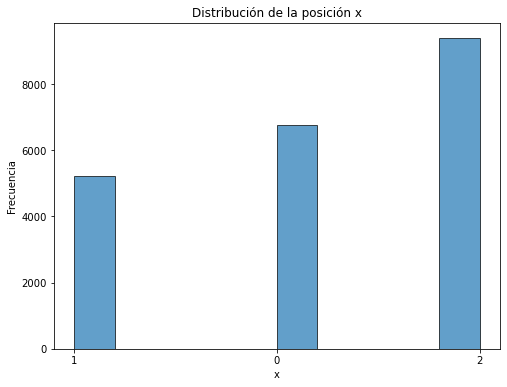

In [13]:
# Extraer la primera posición sin modificar el DataFrame
x_positions = df_train_mapa['etiqueta'].apply(lambda x: x[0])

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Crear el histograma
ax.hist(x_positions, bins=10, edgecolor='black', alpha=0.7)

# Agregar el título y las etiquetas de los ejes
ax.set_title('Distribución de la posición x')
ax.set_xlabel('x')
ax.set_ylabel('Frecuencia')

# Mostrar la figura
plt.show()

In [14]:
from sklearn.utils import class_weight

def aplicar_one_hot_balanceo(df,columa):
    # Crear un DataFrame con las columnas de one-hot encoding
    one_hot_df = pd.get_dummies(df[columa], prefix='label')

    # Unir el DataFrame original con el DataFrame de one-hot encoding
    df = pd.concat([df, one_hot_df], axis=1)

    # Balanceamos los pesos para el entrenamiento
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[columa]),
        y=df[columa]
    )

    # Crear un diccionario de pesos para las clases
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    #Eliminamos la columna original
    df = df.drop(columa, axis=1)
    return df , class_weight_dict

In [15]:
df_train_mapa , pesos_train = aplicar_one_hot_balanceo(df_train_mapa,"etiqueta")
df_valid_mapa , pesos_valid = aplicar_one_hot_balanceo(df_valid_mapa,"etiqueta")
df_test_mapa , pesos_test= aplicar_one_hot_balanceo(df_test_mapa,"etiqueta")

In [16]:
ETIQUETAS = np.array(df_train_mapa.filter(like='label').columns.tolist())

In [17]:
from keras.utils import Sequence

class ImageDataGenerator(Sequence):
    def __init__(self, df , sequence_length ,image_height , image_width , batch_size, filtro, **kwargs):
        self.df = df
        self.image_sequence_length = sequence_length
        self.image_height = image_height
        self.image_width = image_width
        self.batch_size = batch_size
        self.POV = filtro
        super().__init__(**kwargs)  # Llamada al constructor de la clase base

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def cargar_todo(self,fin_df):
        batch_df = self.df.iloc[0:fin_df]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        #y_batch = batch_df[['izquieda', 'derecha', 'delante']].values
        y_batch = np.array(batch_df['mouse_final'].tolist())

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j])    # Obtener la ruta de la imagen
                imagen = Image.fromarray(np.array(imagen)).filter(ImageFilter.SHARPEN)  #Aplicamos Filtro SHARPEN
                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

    def __getitem__(self, index):
        inicio_lote = index * self.batch_size
        final_lote = (index + 1) * self.batch_size

        batch_df = self.df.iloc[inicio_lote:final_lote]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        # Obtener y_batch después del one-hot encoding
        #y_batch = batch_df[['izquieda', 'derecha','delante']].values
        #y_batch = np.array(batch_df['mouse_final'].tolist())

        # Filtrar las columnas que comienzan con 'label'
        y_batch = batch_df.filter(like='label').values

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j+2])    # Obtener la ruta de la imagen
                ancho, alto = imagen.size

                if self.POV == True :
                    imagen = imagen.rotate(2.5, expand=True)
                    # Recorta la imagen (izquierda, superior, derecha, inferior)
                    imagen = imagen.crop((5, 12, ancho - 35, alto-25))
                    imagen = ImageEnhance.Sharpness(imagen)
                    imagen = imagen.enhance(7)  # Aumento de contraste

                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

def comprobar_contenido(X_train , Y_train , num_video):

    fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 1 * 2))

    for i in range(5):
        axs[i].imshow(X_train[num_video][i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()
    print(Y_train[num_video])
    return Y_train[num_video]


class ImageDataGeneratorVAR(ImageDataGenerator):
    def __init__(self, df , sequence_length ,image_height , image_width , batch_size, filtro,autoencoder,encoder = None,**kwargs):
        self.autoencoder = autoencoder
        self.encoder_entrenado = encoder
        super().__init__(df, sequence_length, image_height, image_width, batch_size, filtro, **kwargs)

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def cargar_todo(self,fin_df):
        batch_df = self.df.iloc[0:fin_df]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        #y_batch = batch_df[['izquieda', 'derecha', 'delante']].values
        y_batch = np.array(batch_df['mouse_final'].tolist())

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j])    # Obtener la ruta de la imagen
                imagen = Image.fromarray(np.array(imagen)).filter(ImageFilter.SHARPEN)  #Aplicamos Filtro SHARPEN
                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

    def __getitem__(self, index):
        inicio_lote = index * self.batch_size
        final_lote = (index + 1) * self.batch_size

        batch_df = self.df.iloc[inicio_lote:final_lote]     #Obtenemos un lote del df

        # Inicializar matriz para las imágenes
        #X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))
        X_batch = np.zeros((len(batch_df), self.image_sequence_length, 120, 120, 3))  # Ajustar a 100x100
        
        # Filtrar las columnas que comienzan con 'label'
        y_batch = batch_df.filter(like='label').values

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j+2])    # Obtener la ruta de la imagen
                ancho, alto = imagen.size

                if self.POV == True :
                    imagen = imagen.rotate(2.5, expand=True)
                    # Recorta la imagen (izquierda, superior, derecha, inferior)
                    imagen = imagen.crop((5, 12, ancho - 35, alto-25))
                    imagen = ImageEnhance.Sharpness(imagen)
                    imagen = imagen.enhance(7)  # Aumento de contraste

                imagen = imagen.resize((120, 120))          #(100, 100)
                imagen = np.array(imagen).astype("float32")  / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video
        
        #Para autoencoder
        if self.autoencoder == True:
            return X_batch, X_batch
        else : 
            return X_batch, y_batch

def comprobar_contenido(X_train , num_video):

    fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 1 * 2))

    for i in range(5):
        axs[i].imshow(X_train[num_video][i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

## Loading data

In [18]:
from sklearn.manifold import TSNE

#Graficas para mostrar durante el entrenamiento
def grafica_kl(validation,train):
    epochs = range(1, len(train) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train, label='KL Divergence - Training', color='blue', linewidth=2)
    plt.plot(epochs, validation, label='KL Divergence - Validation', color='orange', linestyle='--', linewidth=2)
    plt.title('KL Divergence durante el Entrenamiento y Validación del VAE', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('KL Divergence', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

def grafica_mc(validation,train):
    epochs = range(1, len(train) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train, label='MSE - Training', color='blue', linewidth=2)
    plt.plot(epochs, validation, label='MSE - Validation', color='orange', linestyle='--', linewidth=2)
    plt.title('MSE durante el Entrenamiento y Validación del VAE', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('MSE', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

import numpy as np

def generate_images_with_noise(cvae, n_images=10, latent_dim=50, num_classes=len(ETIQUETAS)):

    # Muestreo aleatorio de etiquetas en one-hot encoding
    random_labels = np.eye(num_classes)[np.random.choice(num_classes, n_images)]
    print(random_labels)

    # Muestra aleatoria de puntos en el espacio latente
    z_mu = np.random.normal(size=(n_images, latent_dim))  # Mu
    z_rho = np.random.normal(size=(n_images, latent_dim))  # Rho
    sigma = np.exp(z_rho)  # Convierte rho a sigma

    # Muestreo del espacio latente con ruido
    z_samples = z_mu + sigma * np.random.normal(size=z_mu.shape)  # Añadiendo ruido

    # Generar imágenes a partir de los vectores latentes y las etiquetas
    z_lbl_concat = np.concatenate((z_samples,random_labels),axis=1)
    generated_images = cvae.decoder(z_lbl_concat).numpy() 
    return generated_images

def generar_imagenes(model,len_etiquetas,espacio_latente,num_imagenes):
    one_hot_label = np.eye(len_etiquetas)[np.arange(len_etiquetas)].astype(np.uint8)

    for i in range(len(one_hot_label)):
        plt.figure(figsize=(15, 3))
        for o in range(num_imagenes):
            # Generar z aleatorio en el espacio latente
            z = np.random.normal(size=(1, espacio_latente))
            # Generar imágenes decodificadas
            z_lbl_concat = np.concatenate((z,one_hot_label[0].reshape(1, -1)),axis=1)
            img_reconstruida = model.decoder(z_lbl_concat)

            # Mostrar la imagen
            plt.subplot(1, num_imagenes, o + 1)  # Configura la posición de la subfigura
            plt.imshow(img_reconstruida[0], cmap='gray')  # Ajustar reshape según la forma de tus imágenes
            plt.axis('off')
            plt.title(f'Etiqueta: {i}')
    plt.show()

def visualize_latent_space(z_mu, labels, epoch):
    # Reducción de dimensionalidad usando t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    z_mu_2d = tsne.fit_transform(z_mu)

    # Graficar
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_mu_2d[:, 0], z_mu_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(f'Espacio Latente en la Época {epoch}')
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.show()


In [19]:
def concatenar_imgs_serie(X_batch):
    batch_unido = []
    for i in range(X_batch.shape[0]):
        imagen_unida = np.hstack(X_batch[i])
        batch_unido.append(imagen_unida)
    return np.array(batch_unido)

def concatenar_imgs_individual(X_batch):
    batch_independiente = []
    for i in range(X_batch.shape[0]):
        batch_independiente.append(X_batch[i][4])
    return np.array(batch_independiente)

In [20]:
from keras.models import load_model ,Model 

#model_autoencoder = load_model('../modelos/modelo_autoencoder_02.h5')
# Extraer el encoder del modelo autoencoder
#encoder_entrenado = Model(inputs=model_autoencoder.input, outputs=model_autoencoder.get_layer('time_distributed_7').output) 

encoder_entrenado = None
autoencoder = False
# Generador Mapa
altura_img_mini = 188
anchura_img_mini = 260
batch_size = BATCH 

# Generadores para autoencoder
train_generator_Mapa = ImageDataGeneratorVAR(df_train_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True , autoencoder = autoencoder , encoder= encoder_entrenado)
test_generator_Mapa = ImageDataGeneratorVAR(df_test_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True, autoencoder = autoencoder, encoder= encoder_entrenado)
valid_generator_Mapa = ImageDataGeneratorVAR(df_valid_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True, autoencoder = autoencoder, encoder= encoder_entrenado)

713


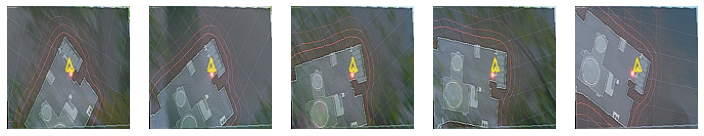

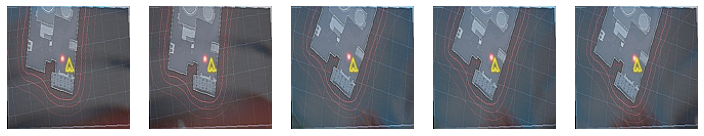

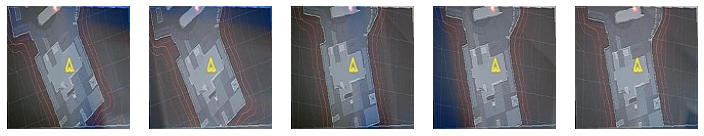

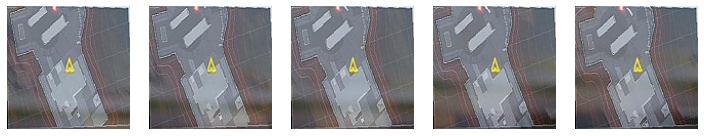

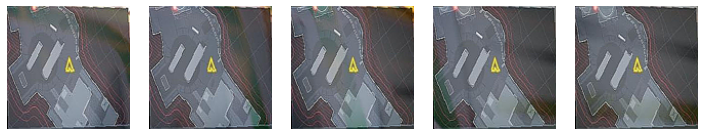

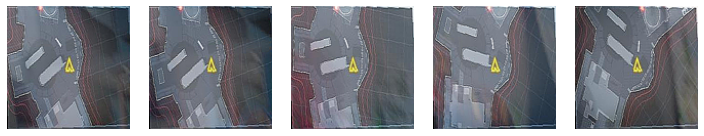

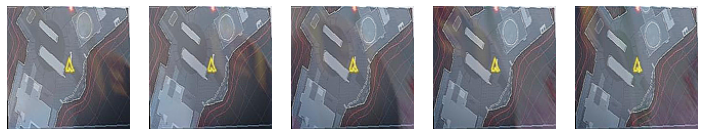

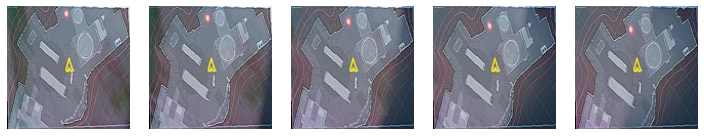

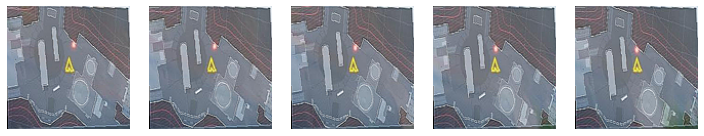

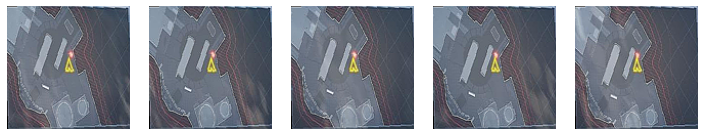

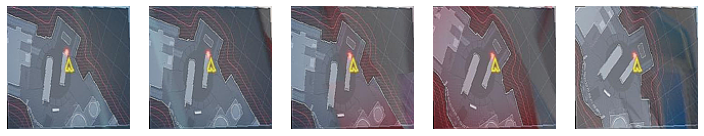

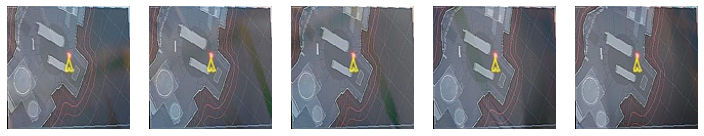

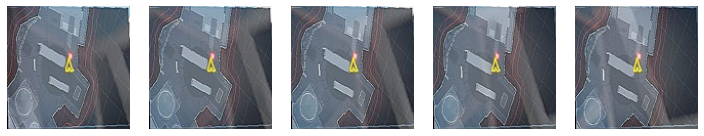

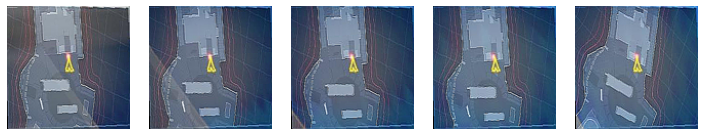

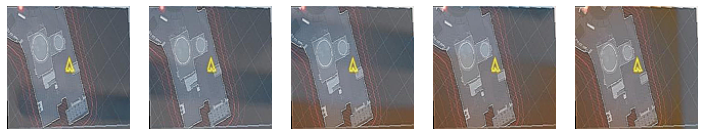

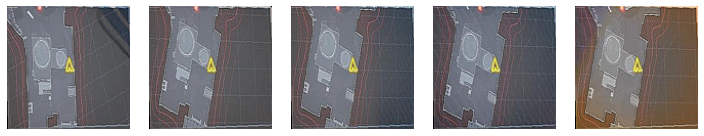

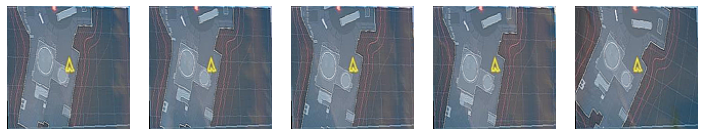

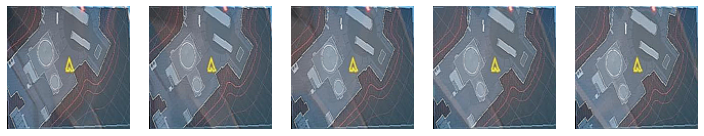

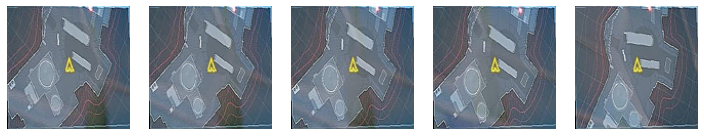

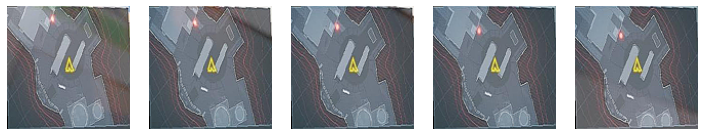

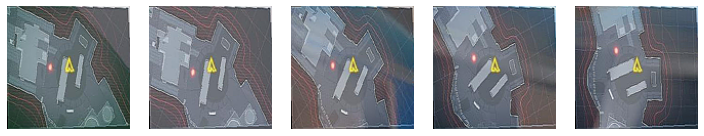

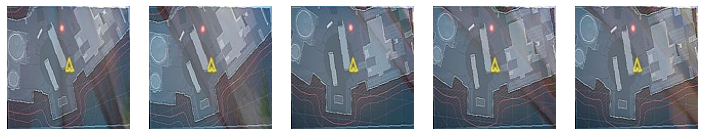

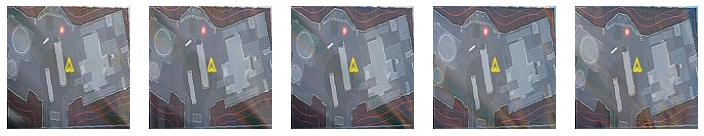

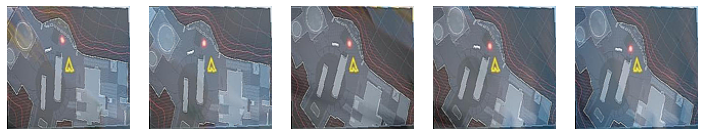

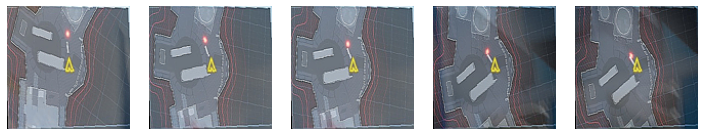

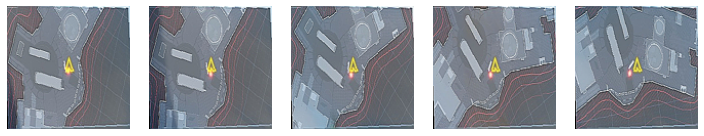

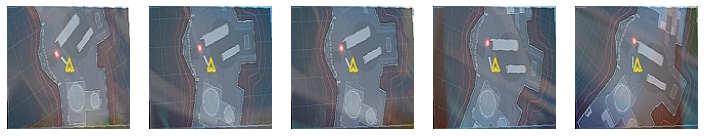

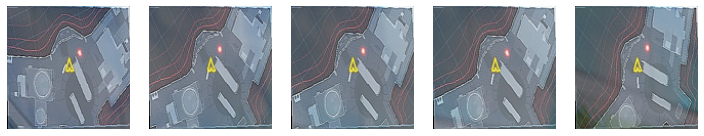

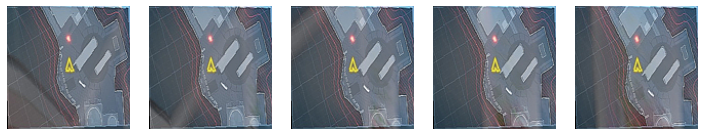

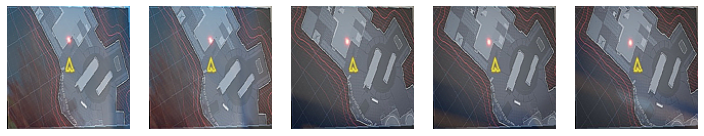

In [21]:
#Cantidad de batches en los que se divide el df
print(train_generator_Mapa.__len__())

#Comprobamos funcionamiento bach
X_batch, Y_batch = train_generator_Mapa.__getitem__(2)

for i in range(0,batch_size):  # 4 es el maximo de conjunto de imagenes del batch creado
    # Seleccionamos ver la posicion numero 0 del batch creado
    comprobar_contenido(X_batch ,i)

In [22]:
Y_batch[2]

array([1, 0, 0], dtype=uint8)

## Model 

### VAE

In [19]:
from keras.models import Model
from keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, UpSampling2D, Flatten ,Cropping2D

class VAE(tf.keras.Model):
    def __init__(self,input_shape,latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder_block = self.get_encoder(input_shape,latent_dim)
        self.decoder_block = self.get_decoder((5, latent_dim))
        self.encoder_block.summary()
        self.decoder_block.summary()

    def call(self,img):
        z_mu,z_rho = self.encoder_block(img)

        epsilon = tf.random.normal(shape=z_mu.shape,mean=0.0,stddev=1.0)
        z = z_mu + tf.math.softplus(z_rho) * epsilon

        decoded_img = self.decoder_block(z)

        return z_mu,z_rho,decoded_img

    def get_decoder(self,latent_dim):
        z = Input(shape=latent_dim)

        # Reshape del vector latente para hacerlo compatible con las convoluciones
        x = TimeDistributed(tf.keras.layers.Reshape((1, 1, 10)))(z)
        x = TimeDistributed(UpSampling2D((12, 17)))(x)

        # Decodificador
        x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(UpSampling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(UpSampling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(UpSampling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(UpSampling2D((2, 2)))(x)

        decoded_img = TimeDistributed(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))(x)
        decoded_img = TimeDistributed(Cropping2D(((2, 2), (6, 6))))(decoded_img)    # Recortar la imagen (2,2)de alto (6,6)ancho    
        
        Decoder = tf.keras.Model(inputs=z,outputs=[decoded_img])
        
        return Decoder
    
    def get_encoder(self,input_shape,latent_dim):
        inputs = Input(shape=input_shape)
        # Codificador
        x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
        x = TimeDistributed(MaxPooling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(MaxPooling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
        x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'))(x)
        encoded = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)

        # Aplanamos la salida para aplicar la capa densa
        flattened = TimeDistributed(Flatten())(encoded)

        mu = tf.keras.layers.Dense(units=latent_dim)(flattened)
        rho = tf.keras.layers.Dense(units=latent_dim)(flattened)
        Encoder = tf.keras.Model(inputs=inputs,outputs=[mu,rho])
        return Encoder

In [ ]:
import sys

def kl_loss(z_mu,z_rho):
    sigma_squared = tf.math.softplus(z_rho) ** 2
    kl_1d = -0.5 * (1 + tf.math.log(sigma_squared) - z_mu ** 2 - sigma_squared)
    # sum over sample dim, average over batch dim
    kl_batch = tf.reduce_mean(tf.reduce_sum(kl_1d,axis=1))
    return kl_batch

def elbo(z_mu,z_rho,decoded_img,original_img):
    # reconstruction loss
    #mse = tf.reduce_mean(tf.reduce_sum(tf.square(original_img - decoded_img),axis=1))
    mse = tf.reduce_mean(tf.reduce_sum(tf.square(original_img - decoded_img), axis=[1, 2, 3, 4]))
    # kl loss
    kl = kl_loss(z_mu,z_rho)
    return mse,kl

def elbo_binary(z_mu, z_rho, decoded_img, original_img):
    # reconstruction loss using binary cross-entropy
    bce = tf.reduce_mean(
        tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(original_img, decoded_img), axis=[1, 2, 3, 4]
        )
    )
    # kl loss
    kl = kl_loss(z_mu, z_rho)    
    return bce, kl


def train(input_shape_pov,
          ESPACIO_LATENTE,
          beta,epochs,
          train_generator,
          valid_generator,
          early_stopping):

    model = VAE(input_shape_pov,ESPACIO_LATENTE)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)

    #Metricas de comportamiento
    kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')
    mse_loss_tracker = tf.keras.metrics.Mean(name='mse_loss')
    val_mse_loss_tracker = tf.keras.metrics.Mean(name='val_mse_loss')

    val_losses = []
    early_stopp = 0


    for epoch in range(epochs):

        # Entrenamiento
        for step in range(len(train_generator)):
            imgs, labels = train_generator_Mapa[step] 

            # training loop
            with tf.GradientTape() as tape:
                # forward pass
                z_mu, z_rho, decoded_imgs = model(imgs)

                # compute loss
                mse, kl = elbo_binary(z_mu, z_rho, decoded_imgs, imgs) #He cambiado por binary por la normalizacion
                loss = mse + beta * kl
            
            # compute gradients
            gradients = tape.gradient(loss, model.trainable_variables)

            # update weights
            optimizer.apply_gradients(zip(gradients, model.variables))

            # update metrics
            kl_loss_tracker.update_state(beta * kl)
            mse_loss_tracker.update_state(mse)

            # Print dinámico para mostrar progreso de los pasos
            sys.stdout.write(f"\rStep {step + 1}/{len(train_generator)} - bce: {mse_loss_tracker.result():.4f}, kl_div: {kl_loss_tracker.result():.4f}")
            sys.stdout.flush()

        print()  # Imprimir nueva línea al final del epoch
            
        # Validación
        for val_step in range(len(valid_generator)):
            val_imgs, val_labels = valid_generator[val_step] 

            # forward pass en validación
            val_z_mu, val_z_rho, val_decoded_imgs = model(val_imgs)

            # compute validation loss
            val_mse, val_kl = elbo(val_z_mu, val_z_rho, val_decoded_imgs, val_imgs)
            val_loss = val_mse + beta * val_kl

            # update validation metrics
            val_mse_loss_tracker.update_state(val_mse)
                    
        # Mostrar métricas al final de cada época
        epoch_kl = kl_loss_tracker.result()
        epoch_mse = mse_loss_tracker.result()
        val_epoch_mse = val_mse_loss_tracker.result()
        print(f'Epoch: {epoch}, bce: {epoch_mse:.4f}, kl_div: {epoch_kl:.4f}, val_mse: {val_epoch_mse:.4f}', flush=True)

        #Callback EarlyStop
        if early_stopp < early_stopping:
            #CheeckPoint Manual
            if not val_losses:
                val_losses.append(val_epoch_mse)
                early_stopp = 0
                print("Primer Validation Loss Minima... "+str(val_epoch_mse.numpy().item()))
                model.save('variational_autoencode.keras')
            else : 
                if val_epoch_mse < min(val_losses): 
                    val_losses.append(val_epoch_mse)
                    early_stopp = 0
                    print("     Nuevo Validation Loss Minima... "+str(val_epoch_mse.numpy().item()))
                    model.save('variational_autoencode.keras')
                else:
                    val_losses.append(val_epoch_mse)
                    early_stopp = early_stopp + 1
                    print("No ha mejorado el modelo desde "+str(np.min(val_losses)))
        else : 
            print("Early stopping activado. No se han visto mejoras en las últimas épocas.")
            break 

        # Reiniciar estados de métricas
        kl_loss_tracker.reset_state()
        mse_loss_tracker.reset_state()
        val_mse_loss_tracker.reset_state()

    return model

### CONDITIONAL VAE

In [23]:
from keras.models import Model
from keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten ,Cropping2D,Conv2DTranspose,Reshape,Dense,BatchNormalization,Dropout
from tensorflow.keras.regularizers import l2

class CVAE(tf.keras.Model):
    def __init__(self,input_shape,latent_dim,etiquetas):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_etiquetas = etiquetas

        encoder_01,encoder_02,decoder_final = self._crear_arquitectura(input_shape)
        self.encoder_primero = encoder_01
        self.encoder_segundo = encoder_02
        self.decoder = decoder_final
        encoder_01.summary()
        encoder_02.summary()
        decoder_final.summary()

    def _crear_arquitectura(self,input_shape):
        #Primer encoder solo Imagen
        encoder_01, size_flatten = self.get_encoder_primero(input_shape)
        # Segundo encoder Imagen + Etiqueta
        encoder_02,size_final_encoder = self.get_encoder_final(self._crear_input(size_flatten,self.num_etiquetas))
        # Pasamor al Decoder
        decoder_final = self.get_decoder(self._crear_input(size_final_encoder,self.num_etiquetas))
        return encoder_01,encoder_02,decoder_final

    def _crear_input(self,input,suma):
        #Sumamos las clases a la tupla de dimensiones
        dimension = []
        dimension.append(input[1] + suma)
        return tuple(dimension)

    def call(self,img,labels,train = True):
        # encoder q(z|x,y)
        img_features_map = self.encoder_primero(img)

        #Diferenciamos para entrenamiento de predicciones
        if train:
            # concat feature maps and one hot label vector
            img_lbl_concat = np.concatenate((img_features_map,labels),axis=1)
        else : 
            # concat feature maps y un vector sin label
            img_lbl_concat = np.concatenate((img_features_map,np.zeros_like(labels)),axis=1)
        
        z_mu,z_rho = self.encoder_segundo(img_lbl_concat)
        #  truco de reparametrización
        epsilon = tf.random.normal(shape=z_mu.shape,mean=0.0,stddev=1.0)
        z = z_mu + tf.math.softplus(z_rho) * epsilon

        # Agregar ruido extra de forma aleatoria
        if tf.random.uniform([]) < 0.5:  # 50% de probabilidad de añadir ruido extra
            noise_stddev = 0.2  # Nivel de ruido extra que deseas añadir
            extra_noise = tf.random.normal(shape=z.shape, mean=0.0, stddev=noise_stddev)
            z += extra_noise

        # decoder p(x|z,y)
        #z_lbl_concat = np.concatenate((z,labels_expanded),axis=-1)
        z_lbl_concat = np.concatenate((z,labels),axis=1)
        img_reconstruida = self.decoder(z_lbl_concat)

        return z_mu,z_rho,img_reconstruida

    def get_encoder_primero(self,input_shape ):
        inputs = Input(shape=input_shape)

        x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01))(inputs)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01))(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01))(x)
        x = MaxPooling2D((2, 2))(x)
        encoded = Flatten()(x)

        Encoder_primero = tf.keras.Model(inputs=inputs,outputs=[encoded])
        return Encoder_primero ,encoded.shape

    def get_encoder_final(self,input_shape):
        inputs = Input(shape=input_shape)
        x = Dense(self.latent_dim, activation='relu')(inputs)
        #Calculamas mu y rho
        mu = tf.keras.layers.Dense(units=self.latent_dim)(x)
        rho = tf.keras.layers.Dense(units=self.latent_dim)(x)
        Encoder_final = tf.keras.Model(inputs=inputs,outputs=[mu,rho])
        return Encoder_final ,rho.shape

    def get_decoder(self,input_shape):
        z = Input(shape=input_shape)
        x = Dense(28800 ,activation="relu",kernel_regularizer=l2(0.01))(z) 
        x = Reshape((15, 15, 128))(x)
        x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="relu",kernel_regularizer=l2(0.01))(x)
        x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same", activation="relu",kernel_regularizer=l2(0.01))(x)
        x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same", activation="relu",kernel_regularizer=l2(0.01))(x)
        decoded_img = Conv2DTranspose(3, (2, 2), padding="same", activation="sigmoid")(x)

        Decoder = tf.keras.Model(inputs=z,outputs=[decoded_img])
        return Decoder

In [24]:
import sys

def kl_loss(z_mu, z_rho):
    # Añadir un pequeño valor (epsilon) para evitar problemas numéricos
    epsilon = 1e-8
    sigma_squared = tf.math.softplus(z_rho) ** 2 + epsilon  # Asegura que la varianza sea positiva
    
    # Cálculo de la pérdida KL
    kl_1d = -0.5 * (1 + tf.math.log(sigma_squared) - tf.square(z_mu) - sigma_squared)
    kl_batch = tf.reduce_mean(tf.reduce_sum(kl_1d, axis=1))
    
    return kl_batch

def elbo(z_mu,z_rho,decoded_img,original_img):
    # reconstruction loss
    mse = tf.reduce_mean(tf.reduce_sum(tf.square(original_img - decoded_img), axis=[1, 2, 3]))
    # kl loss
    kl = kl_loss(z_mu,z_rho)
    return mse,kl

def elbo_free_bits(z_mu, z_rho, decoded_img, original_img, free_bits_threshold=0.1):
    # Reconstruction loss (MSE)
    mse = tf.reduce_mean(tf.reduce_sum(tf.square(original_img - decoded_img), axis=1))
    
    # KL loss con Free Bits
    kl_per_dim = -0.5 * (1 + z_rho - tf.square(z_mu) - tf.exp(z_rho))
    kl_per_dim = tf.maximum(kl_per_dim, free_bits_threshold)  # Aplicamos el límite inferior (Free Bits)
    kl = tf.reduce_sum(kl_per_dim, axis=1)  # Sumamos las pérdidas de cada dimensión
    kl = tf.reduce_mean(kl)  # Promedio total de la pérdida KL
    
    return mse, kl


def train(input_shape_pov,
          ESPACIO_LATENTE,
          initial_beta,final_beta,beta_early,
          lr,
          epochs,
          train_generator,
          valid_generator,
          early_stopping):

    model = CVAE(input_shape_pov,ESPACIO_LATENTE,len(ETIQUETAS))
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

    train_mse_lista = []
    train_kl_lista = []
    val_mse_lista = []
    val_kl_lista = []
    early_stopp = 0
    beta_stop = 0

    # Calcular el incremento de beta por época
    beta = initial_beta
    beta_increment = (final_beta - initial_beta) / ((final_beta - initial_beta)/2)


    for epoch in range(epochs):
        # Ajustar el valor de beta
        if beta < final_beta:
            if beta_stop == beta_early:
                beta = beta + beta_increment
                beta_stop = 0
            else:
                beta_stop = beta_stop + 1

        # Métricas
        kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')
        mse_loss_tracker = tf.keras.metrics.Mean(name='mse_loss')
        # Metricas Validation
        kl_loss_tracker_val = tf.keras.metrics.Mean(name='kl_loss_val')
        mse_loss_tracker_val = tf.keras.metrics.Mean(name='mse_loss_val')       

        # Entrenamiento
        for step in range(len(train_generator)):
            imgs, labels = train_generator[step]
            imgs = concatenar_imgs_individual(imgs)
            mean = np.mean(imgs, axis=(0, 1, 2))
            std = np.std(imgs, axis=(0, 1, 2))
            imgs = (imgs - mean) / std

            # training loop
            with tf.GradientTape() as tape:
                # forward pass
                z_mu, z_rho, decoded_imgs = model(imgs,labels,train=True)
                # Ejemplo de monitoreo dentro del ciclo de entrenamiento

                # compute loss
                mse,kl = elbo(z_mu, z_rho, decoded_imgs, imgs)
                loss = mse + beta * kl  #truco de reparametrización.
            
            # compute gradients
            gradients = tape.gradient(loss, model.trainable_variables)

            # update weights
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # update metrics
            kl_loss_tracker.update_state(kl) 
            mse_loss_tracker.update_state(mse)

            # Print dinámico para mostrar progreso de los pasos
            sys.stdout.write(f"\rStep {step + 1}/{len(train_generator)} - mse_loss: {mse_loss_tracker.result():.4f}, kl_div: {kl_loss_tracker.result():.4f}")
            sys.stdout.write(f" - z_mu min: {tf.reduce_min(z_mu).numpy():.4f}, z_mu max: {tf.reduce_max(z_mu).numpy():.4f}")
            sys.stdout.write(f" - z_rho min: {tf.reduce_min(z_rho).numpy():.4f}, z_rho max: {tf.reduce_max(z_rho).numpy():.4f}")
            sys.stdout.flush()

        print()  # Imprimir nueva línea al final del epoch
            
        # Validación
        for val_step in range(len(valid_generator)):
            val_imgs, val_labels = valid_generator[val_step]
            val_imgs = concatenar_imgs_individual(val_imgs)

            # forward pass en validación
            val_z_mu, val_z_rho, val_decoded_img = model(val_imgs, val_labels, train=False)

            # Compute validation loss
            val_mse, val_kl = elbo(val_z_mu, val_z_rho, val_decoded_img, val_imgs)
            val_loss = val_mse + beta * val_kl

            # Update validation metrics
            kl_loss_tracker_val.update_state(val_kl)  # Use val_kl directly
            mse_loss_tracker_val.update_state(val_mse)
                    
        # Mostrar métricas al final de cada época
        epoch_kl = kl_loss_tracker.result()
        epoch_mse = mse_loss_tracker.result()
        epoch_kl_val = kl_loss_tracker_val.result()
        epoch_mse_val = mse_loss_tracker_val.result()
        print(f'Epoch: {epoch}, mse_train: {epoch_mse:.4f}, kl_div_train: {epoch_kl:.4f}, Beta: {beta:.4f}', flush=True)
        print(f'Epoch: {epoch}, mse_val: {epoch_mse_val:.4f}, kl_div_val: {epoch_kl_val:.4f}, Beta: {beta:.4f}', flush=True)

        train_kl_lista.append(round(epoch_kl.numpy().item(), 4))
        train_mse_lista.append(round(epoch_mse.numpy().item(), 4))
        val_kl_lista.append(round(epoch_kl_val.numpy().item(), 4))
        # Early stopping callback
        if early_stopp < early_stopping:
            # Checkpoint manual
            if not val_mse_lista:
                val_mse_lista.append(round(epoch_mse_val.numpy().item(), 4))
                early_stopp = 0
                print("Primer Validation Loss Mínima: " + str(round(epoch_mse_val.numpy().item(), 4)))
                model.save('variational_autoencoder.keras')
            else:
                if round(epoch_mse_val.numpy().item(), 4) < min(val_mse_lista):
                    val_mse_lista.append(round(epoch_mse_val.numpy().item(), 4))
                    early_stopp = 0
                    print("     Nuevo Validation Loss Mínima: " + str(round(epoch_mse_val.numpy().item(), 4))) 
                    model.save('variational_autoencoder.keras')
                else:
                    val_mse_lista.append(round(epoch_mse_val.numpy().item(), 4))
                    early_stopp += 1
                    print("No ha mejorado el modelo desde " + str(np.min(val_mse_lista)))
        else:
            print("Early stopping activado. No se han visto mejoras en las últimas épocas.")
            break
        
        if epoch > 0:
            grafica_mc(val_mse_lista,train_mse_lista)
            grafica_kl(val_kl_lista,train_kl_lista)
        
        generar_imagenes(model,len(ETIQUETAS),ESPACIO_LATENTE,2)

    return model

In [ ]:
import time

# Registro del tiempo de inicio
start_time = time.time()


ESPACIO_LATENTE = 30
LR = 0.001
height = 120
width = 120
channels = 3
input_shape_pov = (height, width, channels)

model_val = train(
    input_shape_pov,
    ESPACIO_LATENTE,
    initial_beta = 500, final_beta = 510, beta_early = 2,
    epochs=60,
    lr=LR,
    train_generator=train_generator_Mapa,
    valid_generator=valid_generator_Mapa,
    early_stopping = 5
)

# Registro del tiempo de finalización
end_time = time.time()

I0000 00:00:1730502062.134485   37522 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730502062.134668   37522 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730502062.134785   37522 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730502062.134929   37522 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 120, 120, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28803)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │    864,120 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 865,980 (3.30 MB)

 Trainable params: 865,980 (3.30 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28800)          │       979,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 30, 30, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 60, 60, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 120, 120, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 120, 120, 3)    │           195 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,076,275 (4.11 MB)

 Trainable params: 1,076,275 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

2024-11-02 00:01:02.890439: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90400
W0000 00:00:1730502062.921433   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502062.941065   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502062.942245   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502062.946927   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502062.948409   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502062.950786   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502062.952285   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502062.953830   37522 gpu_

Step 1/713 - mse_loss: 53996.0586, kl_div: 4.9518 - z_mu min: -0.6269, z_mu max: 0.5978 - z_rho min: -0.7139, z_rho max: 0.7091

W0000 00:00:1730502063.790513   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502063.791589   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502063.792728   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502063.794204   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502063.795720   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502063.807843   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502063.808766   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502063.809702   37522 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730502063.811263   37522 gp

Step 175/713 - mse_loss: 41427.7617, kl_div: 2.9481 - z_mu min: -0.0070, z_mu max: 0.0071 - z_rho min: 0.0703, z_rho max: 0.16500

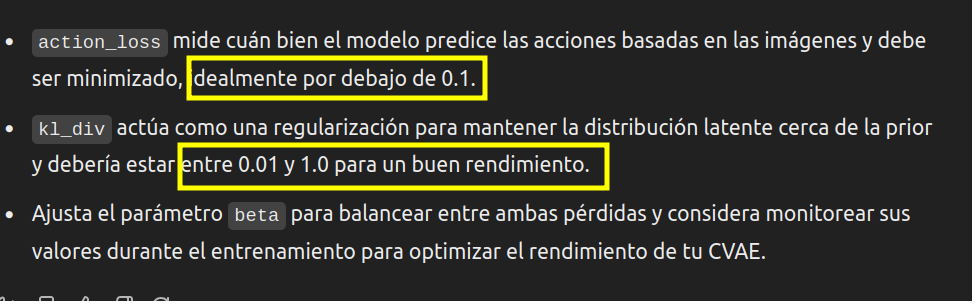

## Inference 

TypeError: Invalid shape (5, 120, 120, 3) for image data

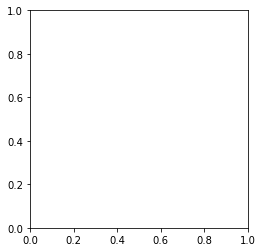

In [23]:
for step in range(5):
    imgs, labels = train_generator_Mapa[step]
    imgs = concatenar_imgs_individual(imgs)
    mean = np.mean(imgs, axis=(0, 1, 2))
    std = np.std(imgs, axis=(0, 1, 2))
    imgs_normalized = (imgs - mean) / std
    plt.imshow(imgs_normalized)
    plt.axis('off')
    plt.show()

In [22]:
# Obtener un lote de prueba (imágenes y etiquetas)
X_batch, y_batch = test_generator_Mapa.__getitem__(0)  # Obtenemos un lote de test
imgs = concatenar_imgs_individual(X_batch)

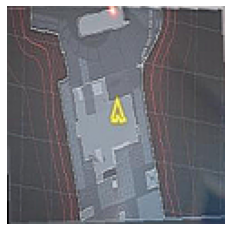

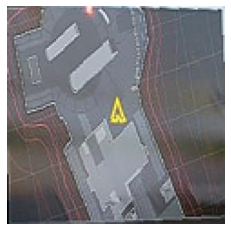

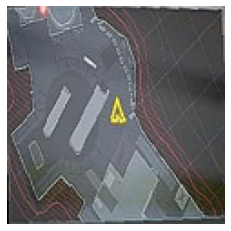

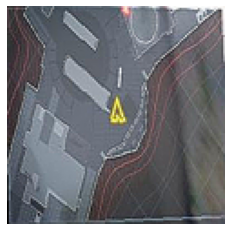

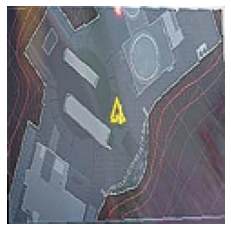

In [23]:
for i in range(0,batch_size):
    plt.imshow(imgs[i])
    plt.axis('off')  # Opcional: oculta los ejes
    plt.show()

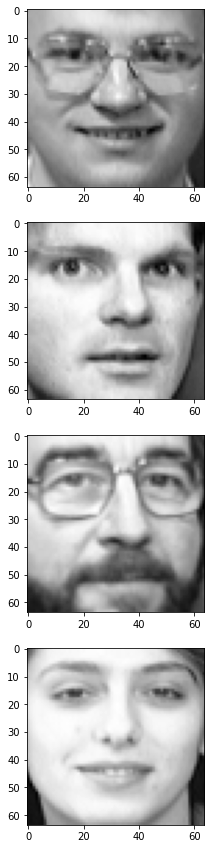

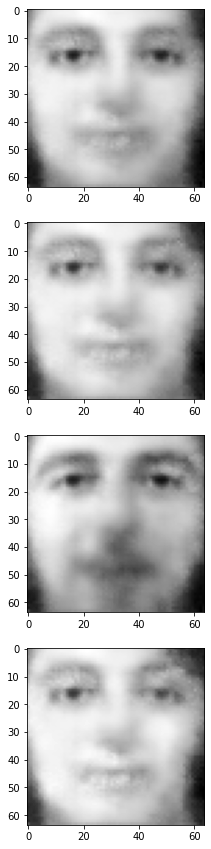

In [69]:
#Testing using decoder

#Image generated 
plt.figure(figsize=(15,15))
img_size=(h_image,w_image)

for i in range(4):
   for val in test_dataset.take(1):
     plt.subplot(4,1,i+1)
     plt.imshow(tf.reshape(val[0][i],img_size),cmap='gray')
plt.show()

plt.figure(figsize=(15,15))
for i in range(4):
  for val in test_dataset.take(1):
    z=encoder_model.predict(np.expand_dims(val[0][i],axis=0))
    output=decoder_model.predict(z)
    output=tf.reshape(output,img_size)
    plt.subplot(4,1,i+1)
    plt.imshow(output,cmap='gray')
plt.show()


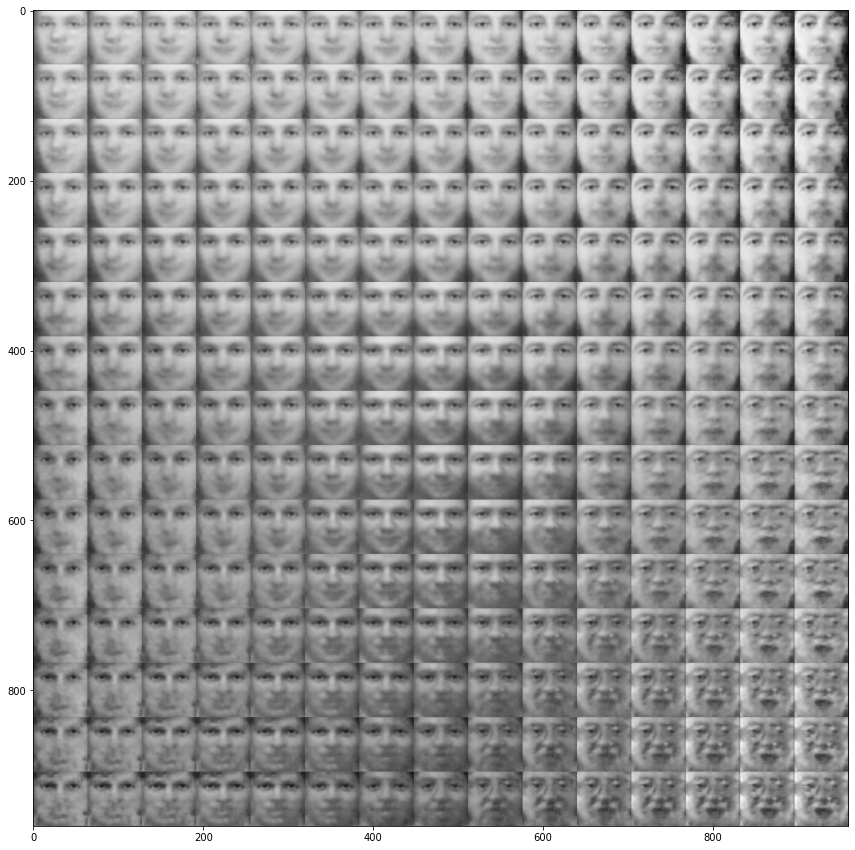

In [72]:
#Uniformally generated Data

plt.figure(figsize=(15,15))
size = 64
n = 15

save_images = np.zeros((size * n, size * n))

grid_x = tf.linspace(-1.5, 1.5, n)
grid_y = tf.linspace(-1.5, 1.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        img = decoder_model(z_sample)
        img = tf.reshape(img[0],img_size)
        save_images[i * size: (i + 1) * size, j * size: (j + 1) * size] = img

plt.imshow(save_images, cmap='gray')
plt.show()


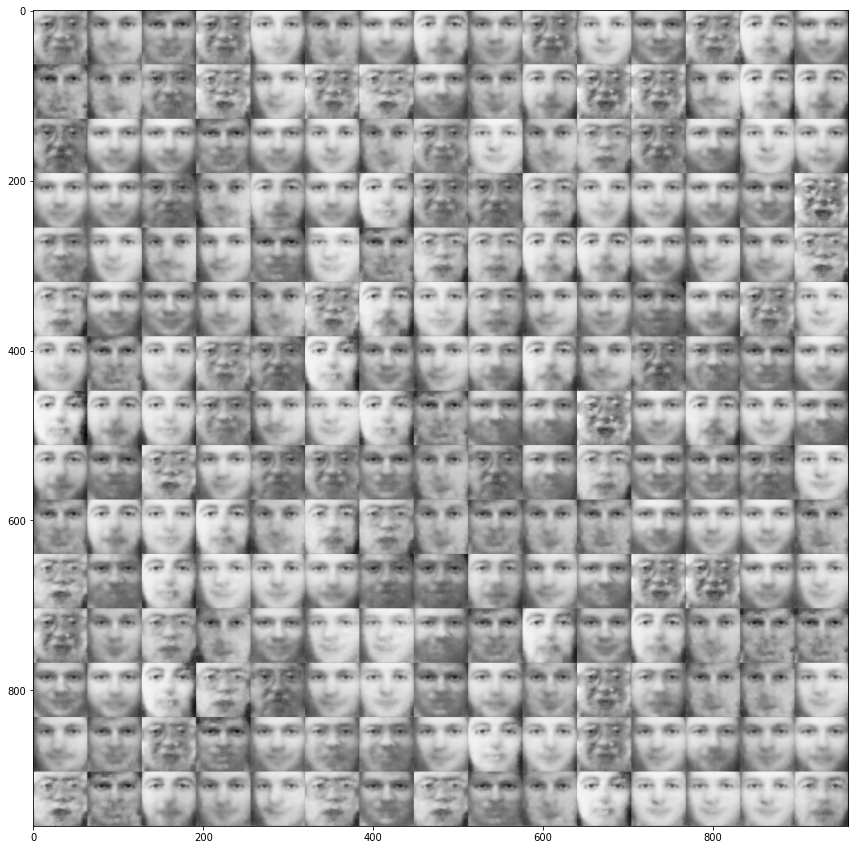

In [73]:
#Randomly Generated Data
n = 15
size = 64
save_images = np.zeros((size * n, size * n))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1.5, 1.5,size=latent_dim)])
        x_decoded = decoder_model.predict(z_sample)
        img = tf.reshape(x_decoded[0],img_size)
        save_images[i * size: (i + 1) * size,j * size: (j + 1) * size] = img

plt.figure(figsize=(15, 15))
plt.imshow(save_images, cmap='Greys_r')
plt.show()


### Copia Seguridad

In [34]:
    def get_encoder_primero(self,input_shape ):
        inputs = Input(shape=input_shape)
        # Codificador
        x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
        x = TimeDistributed(MaxPooling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(MaxPooling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
        x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
        # Aplanamos + LSTM + Densa(Espacio_Latente)
        encoded = TimeDistributed(Flatten())(x)

        Encoder_primero = tf.keras.Model(inputs=inputs,outputs=[encoded])
        return Encoder_primero ,encoded.shape

    def get_encoder_final(self,input_shape):
        inputs = Input(shape=input_shape)
        inputs.shape
        x = LSTM(256 , return_sequences=True)(inputs)
        x = LSTM(256)(x)
        x = Dense(self.latent_dim, activation='relu')(x)
        #Calculamas mu y rho
        mu = tf.keras.layers.Dense(units=self.latent_dim)(x)
        rho = tf.keras.layers.Dense(units=self.latent_dim)(x)
        Encoder_final = tf.keras.Model(inputs=inputs,outputs=[mu,rho])
        return Encoder_final ,rho.shape

    
    def get_decoder(self,input_shape):
        z = Input(shape=input_shape)
        # Reshape del vector latente para hacerlo compatible con las convoluciones
        x = Dense(261120)(z)
        x = Reshape((5, 12, 17, 256))(x)
        x = TimeDistributed(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation="relu"))(x)
        x = TimeDistributed(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="relu"))(x)
        x = TimeDistributed(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same", activation="relu"))(x)
        x = TimeDistributed(Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same", activation="relu"))(x)
        x = TimeDistributed(Conv2DTranspose(3, (3, 3), padding="same", activation="sigmoid"))(x)

        decoded_img = TimeDistributed(Cropping2D(((2, 2), (6, 6))))(x)
        Decoder = tf.keras.Model(inputs=z,outputs=[decoded_img])
        return Decoder




    def get_encoder_primero(self,input_shape ):
        inputs = Input(shape=input_shape)
        # Codificador
        x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
        x = TimeDistributed(MaxPooling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(MaxPooling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
        x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
        x = TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
        # Aplanamos
        encoded = TimeDistributed(Flatten())(x)

        Encoder_primero = tf.keras.Model(inputs=inputs,outputs=[encoded])
        return Encoder_primero ,encoded.shape

    def get_encoder_final(self,input_shape):
        inputs = Input(shape=input_shape)
        x = LSTM(512 , return_sequences=True)(inputs)
        x = LSTM(512)(x)
        x = Dense(self.latent_dim, activation='relu')(x)
        #Calculamas mu y rho
        mu = tf.keras.layers.Dense(units=self.latent_dim)(x)
        rho = tf.keras.layers.Dense(units=self.latent_dim)(x)
        Encoder_final = tf.keras.Model(inputs=inputs,outputs=[mu,rho])
        return Encoder_final ,rho.shape

    
    def get_decoder(self,input_shape):
        z = Input(shape=input_shape)
        # Reshape del vector latente para hacerlo compatible con las convoluciones
        x = Dense(138240)(z) 
        x = Reshape((5, 6, 9, 512))(x)
        x = TimeDistributed(Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu"))(x)
        x = TimeDistributed(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation="relu"))(x)
        x = TimeDistributed(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="relu"))(x)
        x = TimeDistributed(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same", activation="relu"))(x)
        x = TimeDistributed(Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same", activation="relu"))(x)
        x = TimeDistributed(Conv2DTranspose(3, (3, 3), padding="same", activation="sigmoid"))(x)

        decoded_img = TimeDistributed(Cropping2D(((2, 2), (14, 14))))(x)
        Decoder = tf.keras.Model(inputs=z,outputs=[decoded_img])
        return Decoder

In [78]:
input_shape_pov

(5, 188, 260, 3)

In [77]:
imgs.shape

(7, 5, 188, 260, 3)

In [76]:
new_batch.shape

(7, 188, 1300, 3)

In [96]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten ,Cropping2D,Conv2DTranspose,Reshape,Dense,BatchNormalization,Dropout
from tensorflow.keras.regularizers import l2

def get_encoder_primero(input_shape,espacio_latente ):
    inputs = Input(shape=input_shape)
    # Codificador
    x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01))(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01))(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.01))(x)
    x = MaxPooling2D((2, 2))(x)
    encoded = Flatten()(x)

    Encoder_primero = tf.keras.Model(inputs=inputs,outputs=[encoded])
    return Encoder_primero ,encoded.shape

def get_encoder_final(input_shape,latent_dim):
    inputs = Input(shape=input_shape)
    x = Dense(latent_dim, activation='relu')(inputs)
    #Calculamas mu y rho
    mu = tf.keras.layers.Dense(units=latent_dim)(x)
    rho = tf.keras.layers.Dense(units=latent_dim)(x)
    Encoder_final = tf.keras.Model(inputs=inputs,outputs=[mu,rho])
    return Encoder_final ,rho.shape

def get_decoder(input_shape):
    z = Input(shape=input_shape)
    x = Dense(28800 ,activation="relu",kernel_regularizer=l2(0.01))(z) 
    x = Reshape((15, 15, 128))(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="relu",kernel_regularizer=l2(0.01))(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same", activation="relu",kernel_regularizer=l2(0.01))(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same", activation="relu",kernel_regularizer=l2(0.01))(x)
    decoded_img = Conv2DTranspose(3, (2, 2), padding="same", activation="sigmoid")(x)
    print(decoded_img.shape)

    Decoder = tf.keras.Model(inputs=z,outputs=[decoded_img])
    return Decoder


ESPACIO_LATENTE = 10
height = 120
width = 120
channels = 3
input_shape_pov = (height, width, channels)

#Primer encoder solo Imagen
encoder, size_flatten = get_encoder_primero(input_shape_pov,ESPACIO_LATENTE)
#Sumamos las clases a la tupla de dimensiones
dimension = []
dimension.append(size_flatten[1] + len(ETIQUETAS))
size_flatten_etiqueta = tuple(dimension)

# Segundo encoder Imagen + Etiqueta
Encoder_final,size_final_encoder = get_encoder_final(size_flatten_etiqueta,ESPACIO_LATENTE)
dimension = []
dimension.append(size_final_encoder[1] + len(ETIQUETAS))
size_flatten_etiqueta = tuple(dimension)
# Pasamor al Decoder
decoder_final = get_decoder(size_flatten_etiqueta)

(None, 120, 120, 3)


In [97]:
encoder.summary()
Encoder_final.summary()
decoder_final.summary()

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_86 (InputLayer)     │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 120, 120, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 28800)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_80"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_87      │ (None, 28803)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_115 (Dense)   │ (None, 10)        │    288,040 │ input_layer_87[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_116 (Dense)   │ (None, 10)        │        110 │ dense_115[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_117 (Dense)   │ (None, 10)        │        110 │ dense_115[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 288,260 (1.10 MB)

 Trainable params: 288,260 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_88 (InputLayer)     │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 28800)          │       403,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_28 (Reshape)            │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_88             │ (None, 30, 30, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_89             │ (None, 60, 60, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_90             │ (None, 120, 120, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_91             │ (None, 120, 120, 3)    │           195 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,275 (1.91 MB)

 Trainable params: 500,275 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Copia Seguridad
from keras.models import Model
from keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, UpSampling2D, Flatten ,Cropping2D

class CVAE(tf.keras.Model):
    def __init__(self,input_shape,latent_dim,etiquetas):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_etiquetas = etiquetas

        encoder_01,encoder_02,decoder_final = self._crear_arquitectura(input_shape)
        self.encoder_primero = encoder_01
        self.encoder_segundo = encoder_02
        self.decoder = decoder_final
        encoder_01.summary()
        encoder_02.summary()
        decoder_final.summary()

    def _crear_arquitectura(self,input_shape):
        #Primer encoder solo Imagen
        encoder_01, size_flatten = self.get_encoder_primero(input_shape)
        # Segundo encoder Imagen + Etiqueta
        encoder_02,size_final_encoder = self.get_encoder_final(self._crear_input(size_flatten,self.num_etiquetas),self.latent_dim)
        # Pasamor al Decoder
        decoder_final = self.get_decoder(self._crear_input(size_final_encoder,self.num_etiquetas))
        return encoder_01,encoder_02,decoder_final

    def _crear_input(self,input,suma):
        #Sumamos las clases a la tupla de dimensiones
        dimension = []
        dimension.append(input[1])
        dimension.append(input[2] + suma)
        return tuple(dimension)

    def call(self,img,labels,train = True):
        # encoder q(z|x,y)
        img_features_map = self.encoder_primero(img)

        labels_expanded = np.expand_dims(labels, axis=1)  # (batch_size, 1, num_labels)
        labels_expanded = np.tile(labels_expanded, (1, img_features_map.shape[1], 1))  # (batch_size, timesteps, num_labels)

        #Diferenciamos para entrenamiento de predicciones
        if train:
            # concat feature maps and one hot label vector
            img_lbl_concat = np.concatenate((img_features_map,labels_expanded),axis=-1)
        else : 
            # concat feature maps y un vector sin label
            img_lbl_concat = np.concatenate((img_features_map,np.zeros_like(labels_expanded)),axis=-1)
        
        z_mu,z_rho = self.encoder_segundo(img_lbl_concat)
        #  truco de reparametrización
        epsilon = tf.random.normal(shape=z_mu.shape,mean=0.0,stddev=1.0)
        z = z_mu + tf.math.softplus(z_rho) * epsilon

        # Agregar ruido extra de forma aleatoria
        if tf.random.uniform([]) < 0.4:  # 40% de probabilidad de añadir ruido extra
            noise_stddev = 0.2  # Nivel de ruido extra que deseas añadir
            extra_noise = tf.random.normal(shape=z.shape, mean=0.0, stddev=noise_stddev)
            z += extra_noise

        # decoder p(x|z,y)
        #z_lbl_concat = np.concatenate((z,labels_expanded),axis=-1)
        z_lbl_concat = np.concatenate((z,labels),axis=1)
        img_reconstruida = self.decoder(z_lbl_concat)

        return z_mu,z_rho,img_reconstruida

    def get_encoder_primero(self,input_shape):
        inputs = Input(shape=input_shape)
        # Codificador
        x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
        x = TimeDistributed(MaxPooling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(MaxPooling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
        x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'))(x)
        encoded = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)

        # Aplanamos la salida para aplicar la capa densa
        flattened = TimeDistributed(Flatten())(encoded)

        Encoder_primero = tf.keras.Model(inputs=inputs,outputs=[flattened])
        return Encoder_primero ,flattened.shape



    def get_encoder_final(self,input_shape,latent_dim):
        inputs = Input(shape=input_shape)
        #Calculamas mu y rho
        mu = TimeDistributed(tf.keras.layers.Dense(units=latent_dim)(inputs))
        rho = TimeDistributed(tf.keras.layers.Dense(units=latent_dim)(inputs))
        Encoder_final = tf.keras.Model(inputs=inputs,outputs=[mu,rho])
        return Encoder_final ,rho.shape
    
    def get_decoder(self,input_shape):
        z = Input(shape=input_shape)

        # Reshape del vector latente para hacerlo compatible con las convoluciones
        x = TimeDistributed(tf.keras.layers.Reshape((1, 1, self.latent_dim+self.num_etiquetas)))(z)
        x = TimeDistributed(UpSampling2D((12, 17)))(x)

        # Decodificador
        x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(UpSampling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(UpSampling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(UpSampling2D((2, 2)))(x)
        x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(x)
        x = TimeDistributed(UpSampling2D((2, 2)))(x)

        decoded_img = TimeDistributed(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))(x)
        decoded_img = TimeDistributed(Cropping2D(((2, 2), (6, 6))))(decoded_img)    # Recortar la imagen (2,2)de alto (6,6)ancho    
        
        Decoder = tf.keras.Model(inputs=z,outputs=[decoded_img])
        return Decoder

In [ ]:
#Primer encoder solo Imagen
encoder_block, size_flatten = get_encoder_primero(input_shape_pov)
#Sumamos las clases a la tupla de dimensiones
dimension = []
dimension.append(size_flatten[1])
dimension.append(size_flatten[2] + len(ETIQUETAS))
size_flatten_etiqueta = tuple(dimension)

# Segundo encoder Imagen + Etiqueta
Encoder_final,size_final_encoder = get_encoder_final(size_flatten_etiqueta,ESPACIO_LATENTE)

dimension = []
dimension.append(size_flatten[1])
dimension.append(size_flatten[2] + ESPACIO_LATENTE)
size_input_decoder = tuple(dimension)
# Pasamor al Decoder
decoder_final = get_decoder_custom(size_input_decoder,len(ETIQUETAS))


encoder_block.summary()
Encoder_final.summary()
decoder_final.summary()

In [ ]:
        #Callback EarlyStop
        if early_stopp < early_stopping:
            #CheeckPoint Manual
            if not val_losses:
                val_losses.append(val_epoch_action_loss)
                early_stopp = 0
                print("Primer Validation Loss Minima... "+str(val_epoch_action_loss.numpy().item()))
                model.save('variational_autoencode.keras')
            else : 
                if val_loss < min(val_losses): 
                    val_losses.append(val_epoch_action_loss)
                    early_stopp = 0
                    print("     Nuevo Validation Loss Minima... "+str(val_epoch_action_loss.numpy().item()))
                    model.save('variational_autoencode.keras')
                else:
                    val_losses.append(val_epoch_action_loss)
                    early_stopp = early_stopp + 1
                    print("No ha mejorado el modelo desde "+str(np.min(val_losses)))
        else : 
            print("Early stopping activado. No se han visto mejoras en las últimas épocas.")
            break 